In [5]:
import numpy as np
from getdata import load
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import hamming_loss
from keras import backend as K
K.set_image_dim_ordering('th')

In [2]:
x_train, x_test, y_train, y_test = load()

In [3]:
x_train = x_train.astype('float32')
x_test  = x_test.astype('float32')

x_train /= 255
x_test /= 255

In [4]:
model = Sequential()
model.add(Convolution2D(32, kernel_size=(3, 3),padding='same',input_shape=(3 , 100, 100)))
model.add(Activation('relu'))
model.add(Convolution2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Convolution2D(64,(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Convolution2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(5))
model.add(Activation('sigmoid'))

In [5]:
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

model.load_weights("weights.hdf5")

In [6]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 32, 100, 100)  896         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 32, 100, 100)  0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 32, 98, 98)    9248        activation_1[0][0]               
____________________________________________________________________________________________________
activation_2 (Activation)        (None, 32, 98, 98)    0           convolution2d_2[0][0]            
___________________________________________________________________________________________

In [7]:
out = model.predict_proba(x_test)
out = np.array(out)

400/400 [==============================] - 8s     


In [8]:
out

array([[  3.64471078e-02,   4.73899484e-01,   6.47043407e-01,
          1.95887294e-02,   3.30646187e-01],
       [  4.43876125e-02,   9.62344115e-04,   2.85109848e-01,
          9.79765773e-01,   4.65661250e-02],
       [  3.01076248e-02,   4.73674433e-03,   6.14792824e-01,
          9.79676723e-01,   3.98653932e-03],
       ..., 
       [  1.34005740e-01,   4.48708097e-03,   3.55827630e-01,
          9.29459333e-01,   3.27085145e-02],
       [  4.18195594e-03,   4.42525372e-02,   5.81168115e-01,
          3.68096330e-03,   4.48222280e-01],
       [  3.09060942e-02,   5.13285398e-01,   5.07765353e-01,
          6.89628022e-03,   2.32848048e-01]], dtype=float32)

In [9]:
threshold = np.arange(0.1,0.9,0.1)

acc = []
accuracies = []
best_threshold = np.zeros(out.shape[1])
for i in range(out.shape[1]):
    y_prob = np.array(out[:,i])
    for j in threshold:
        y_pred = [1 if prob>=j else 0 for prob in y_prob]
        acc.append( matthews_corrcoef(y_test[:,i],y_pred))
    acc   = np.array(acc)
    index = np.where(acc==acc.max()) 
    accuracies.append(acc.max()) 
    best_threshold[i] = threshold[index[0][0]]
    acc = []

In [10]:
best_threshold

array([ 0.6,  0.3,  0.4,  0.3,  0.7])

In [11]:
y_pred = np.array([[1 if out[i,j]>=best_threshold[j] else 0 for j in range(y_test.shape[1])] for i in range(len(y_test))])

In [12]:
y_pred  #predicted labels

array([[0, 1, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 1, 1, 0],
       ..., 
       [0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0],
       [0, 1, 1, 0, 0]])

In [13]:
y_test #actual labels

array([[0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0],
       ..., 
       [0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0]])

In [14]:
hamming_loss(y_test,y_pred)  #the loss should be as low as possible and the range is from 0 to 1

0.1395

In [15]:
total_correctly_predicted = len([i for i in range(len(y_test)) if (y_test[i]==y_pred[i]).sum() == 5])

In [16]:
total_correctly_predicted/400. #exact accuracy for eg y_pred = [0,0,1,1,1] and y_test=[0,0,1,1,1]

0.54

In [17]:
total_correctly_predicted

216

In [18]:
from IPython.display import Image

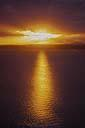

In [19]:
Image(filename='test_image.jpg') 

In [20]:
import cv2

In [21]:
img = cv2.imread("test_image.jpg")

In [22]:
img.shape

(128, 85, 3)

In [23]:
img = cv2.resize(img,(100,100))

In [24]:
img.shape

(100, 100, 3)

In [25]:
img = img.transpose((2,0,1))

In [26]:
img.shape

(3, 100, 100)

In [27]:
img = img.astype('float32')

In [28]:
img = img/255

In [29]:
img = np.expand_dims(img,axis=0)

In [30]:
img.shape

(1, 3, 100, 100)

In [31]:
pred = model.predict(img)

In [32]:
pred

array([[ 0.01491354,  0.00838183,  0.64092934,  0.99065214,  0.00579561]], dtype=float32)

In [33]:
y_pred = np.array([1 if pred[0,i]>=best_threshold[i] else 0 for i in range(pred.shape[1])])

In [34]:
y_pred

array([0, 0, 1, 1, 0])

In [35]:
classes = ['desert','mountains','sea','sunset','trees']

In [36]:
[classes[i] for i in range(5) if y_pred[i]==1 ]  #extracting actual class name

['sea', 'sunset']